# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [565]:
from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get the time series


In [566]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [567]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0708100000, Description: Arvejas (guisantes, chicharos) frescos o refrigerados


### Daily kilogram's price time series

In [568]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()

### Daily total (net) weight exporter time series

In [569]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})

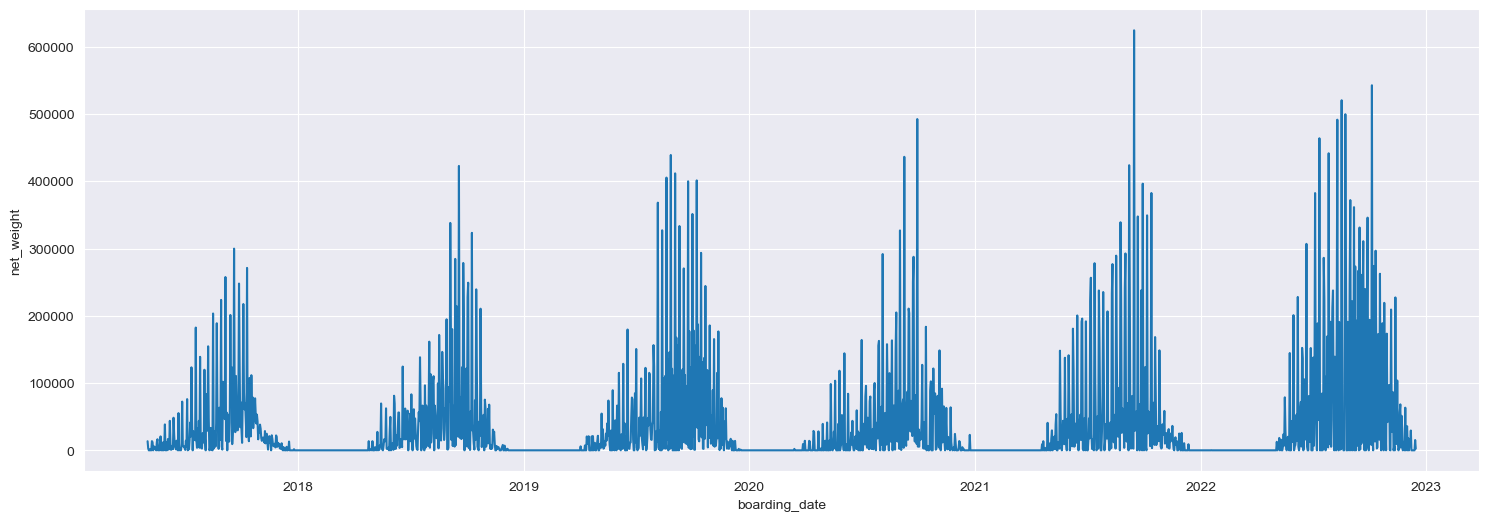

In [570]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x="boarding_date", y="net_weight", data=net_weight)
plt.show()

In [571]:
# # # Generate the cyclic time granularities
# import numpy as np
# #
# # # First get irregular periods for quasi-circular granularities
# net_weight['days_in_month'] = pd.PeriodIndex(net_weight.index, freq='M').end_time.day
# net_weight['days_in_year'] = pd.PeriodIndex(net_weight.index, freq='Y').end_time.dayofyear
# net_weight['weeks_in_month'] = np.ceil(pd.PeriodIndex(net_weight.index, freq='M').end_time.day/7).astype(np.int64)

In [572]:
# net_weight['day_in_month']= net_weight.index.day % net_weight['days_in_month']
# net_weight

In [598]:
import numpy as np
# Generate the cyclic time granularities
net_weight['day_in_month']= net_weight.index.day
net_weight['day_in_quarter']= net_weight.index.dayofyear - pd.PeriodIndex(net_weight.index, freq='Q').start_time.dayofyear + 1
net_weight['day_in_semester']= net_weight.index.dayofyear - net_weight.index.map(lambda x: pd.Timestamp(year=x.year, month=1 if x.month <= 6 else 7, day=1)).dayofyear + 1
net_weight['day_in_year'] = net_weight.index.dayofyear
net_weight['week_in_fortnight'] = [np.ceil((i%14+1)/7).astype(int) for i in range(0, len(net_weight))]
net_weight['week_in_month'] =  np.ceil(net_weight.index.day/7).astype(np.int64)
net_weight['week_in_quarter'] = net_weight.index.isocalendar().week - pd.PeriodIndex(net_weight.index, freq='Q').start_time.week + 1

C:\Users\sergio\AppData\Local\Temp\ipykernel_23712\2852022138.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  net_weight['week_in_quarter'] = net_weight.index.isocalendar().week - pd.PeriodIndex(net_weight.index, freq='Q').start_time.week + 1


In [597]:
net_weight

,net_weight,day_in_month,day_in_quarter,day_in_semester,day_in_year,week_in_fortnight,week_in_month,week_in_quarter
boarding_date,,,,,,,,
2017-05-02,13500.0,2,32,122,122,1,1,6
2017-05-03,2697.0,3,33,123,123,1,1,6
2017-05-04,0.0,4,34,124,124,1,1,6
2017-05-05,0.0,5,35,125,125,1,1,6
2017-05-06,1620.0,6,36,126,126,1,1,6
...,...,...,...,...,...,...,...,...
2022-12-11,0.0,11,72,164,345,1,2,11
2022-12-12,0.0,12,73,165,346,1,2,12
2022-12-13,0.0,13,74,166,347,2,2,12


In [515]:
# Seasonal plot (yearly)
plt.figure(figsize=(18,6))
sns.lineplot(x=pd.to_datetime(net_weight['boarding_date']).dt.week,
            y=net_weight['net_weight'],
            legend='full',
            palette=sns.color_palette("dark:salmon_r", as_cmap=True),
            errorbar=None)
plt.legend(bbox_to_anchor=(1, 1), loc=2);
plt.show()

KeyError: 'boarding_date'

<Figure size 1800x600 with 0 Axes>

In [ ]:
sns.boxplot(x=pd.to_datetime(net_weight['boarding_date']).dt.day,
            y=net_weight['net_weight'],
            hue=pd.to_datetime(net_weight['boarding_date']).dt.month)
plt.show()